# Projet Steganographie texte dans une image rbv

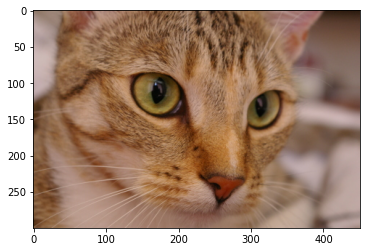

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

img = skimage.data.chelsea()
plt.imshow(img)
plt.show()

In [57]:
print("Y :", img.shape[0])
print("X :", img.shape[1])
print("Image en couleur donc", img.shape[2],"pixels par pixel")

print("\nNombre de pixels total que l'on peut coder:", img.shape[0]*img.shape[1]*img.shape[2])

Y : 300
X : 451
Image en couleur donc 3 pixels par pixel

Nombre de pixels total que l'on peut coder: 405900


## Etape 1 : Transformer chaque caractère en code ASCII puis binaire

In [65]:
message = "L'emploi du cannabis pour un usage thérapeutique suscite toujours bien des polémiques. Pourtant, ses effets analgésiques sont connus depuis longtemps. Les cannabinoïdes oraux, comme le tétrahydrocannabinol (THC), seuls ou en association, ont montré une efficacité contre des douleurs neuropathiques, la polyarthrite rhumatoïde et la fibromyalgie. Un dérivé du cannabis (le Sativex*) est même homologué dans certains pays. Et une nouvelle étude vient confirmer les effets bénéfiques du cannabis dans les douleurs chroniques. Ces douleurs, dues à des lésions ou à des dysfonctionnements du système nerveux central, sont très difficiles à soulager. Les traitements proposés - opioïdes, anti-épileptiques, antidépresseurs et anesthésiques locaux - ont une efficacité variable et de nombreux effets secondaires. Selon Mark Ware de l'université McGill à Montréal et ses collègues, cela explique pourquoi 10 à 15 % des patients souffrant de douleurs chroniques non cancéreuses et de sclérose en plaques fument du cannabis. Ces chercheurs ont mené un essai avec quatre puissances de THC (0 %, 2,5 %, 6 % et 9,4 %) testées sur quatre périodes de 14 jours auprès de 23 personnes ayant des douleurs neuropathiques post-traumatiques ou post-chirurgicales. Résultat : ceux qui ont reçu du THC à 9,4 % se sont endormis plus facilement, plus vite, plus profondément, et la qualité de leur sommeil était la meilleure. Ils étaient moins anxieux et moins dépressifs que les autres. Côté effets secondaires, les plus fréquents étaient des maux de tête, une sécheresse des yeux, une sensation de brûlure dans des zones de douleur neuropathique, des évanouissements, des engourdissements et de la toux. Une euphorie a été notée 3 fois après la première dose d'un cycle, mais la quantité n'était pas suffisante pour induire l'effet recherché lors d'un usage récréatif, précisent les chercheurs dont les travaux ont été financés par les Canadian Institutes of Health Research. Ils recommandent de poursuivre les études."

In [66]:
def string_to_binaire(message):
    liste_de_binaire = []
    
    # On ajoute un mot-code STOP à la fin du message pour simplifier le décodage
    # Hint : STOP s'écrit en binaire : 01010011, 01010100, 01001111, 01010000
    STOP = ['01010011', '01010100', '01001111', '01010000']
    
    for lettre in message :
        lettre_asci = ord(lettre)
        lettre_binaire = bin(lettre_asci)
        lettre_binaire = lettre_binaire[2:].zfill(8)
        liste_de_binaire.append(lettre_binaire)
        
    return liste_de_binaire + STOP

liste_binaire = string_to_binaire(message)
    
def ligne_binaire(liste):
    ''' 
    ligne binaire est une fonction permettant d'obtenir à partir d'une liste de suite d'octet,
    une seule suite d'octet encodant l'intégralité du message 
    
    liste : le message sous forme de liste de caractères encodé en binaire 
    
    retourne le message écrit sous forme binaire avec des caractères encodés sur 8 bits '''
    chiffres = ""
    for i in liste:
        chiffres += i
        
    return chiffres

message_bin_flat = ligne_binaire(liste_binaire)

In [67]:
message_bin_flat

'010011000010011101100101011011010111000001101100011011110110100100100000011001000111010100100000011000110110000101101110011011100110000101100010011010010111001100100000011100000110111101110101011100100010000001110101011011100010000001110101011100110110000101100111011001010010000001110100011010001110100101110010011000010111000001100101011101010111010001101001011100010111010101100101001000000111001101110101011100110110001101101001011101000110010100100000011101000110111101110101011010100110111101110101011100100111001100100000011000100110100101100101011011100010000001100100011001010111001100100000011100000110111101101100111010010110110101101001011100010111010101100101011100110010111000100000010100000110111101110101011100100111010001100001011011100111010000101100001000000111001101100101011100110010000001100101011001100110011001100101011101000111001100100000011000010110111001100001011011000110011111101001011100110110100101110001011101010110010101110011001000000111001101101111011011100111010

On remplace le dernier bit de chaque couleur de chaque pixel par les bits qu'on veut cacher

In [68]:
import random

def generate_cle(coef, img, message):
    nbr_pixels = img.shape[0]*img.shape[1]*img.shape[2]
    MAX = nbr_pixels-1
    
    random.seed(coef)
    liste = [int(random.random()*nbr_pixels-1) for _ in range(MAX)]
    indexes = np.unique(liste, return_index=True)[1]
    return [liste[index] for index in sorted(indexes)]

liste = generate_cle(23, img, message)
max(liste)

405898

In [69]:
lsb = 3

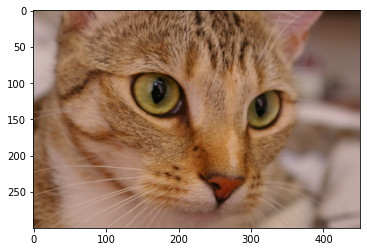

In [70]:
def encoder_image(img, chiffres, lsb, cle):
    # Tableau de string : va contenir les valeurs de nos bits (rouge,bleu,vert) en binaire
    # img_bin = np.chararray((img.shape[0], img.shape[1], img.shape[2]), itemsize=8)
    
    
    # 1 : flatten toute l'image
    # sur chaque pixel qui va être codé : 
         # on va créer un temp qui prend la valeur binaire
         # decode("utf-8") ce temp
         # on la modifie avec le nouveau message
         # int(temp, 2)
         # on remplace la valeur de l'image par le temp
    
    img_flat = img.flatten().copy()
    
    for case in cle[:(len(chiffres)//lsb)+1] :
        temp = bin(img_flat[case])[2:].zfill(8)
        #temp = temp.decode("utf-8")
        
        temp = temp[:8-lsb] + chiffres[0:lsb]
        chiffres = chiffres[lsb:]
        
        temp = int(temp, 2)
        
        img_flat[case] = temp
    
    img_encoded = np.reshape(img_flat, img.shape)
        
    return img_encoded

img_encoded = encoder_image(img, message_bin_flat, lsb, liste)
plt.imshow(img_encoded)
plt.show()

## Etape 4 : Decoder le message

In [71]:
def find_secret_message(image_encoded, lsb, cle):

    # flatten l'image
    # pour chaque pixel de la liste "clé" :
        # on met en binaire
        # on récupère les 2 bits (car lsb = 2)
        # quand on a 8 bits : on stocke la variable (binaire) dans une liste (message_encoded_bin.append(bits))
        # quand on a 4 variables dans la liste : on regarde si ça fait le mot STOP
        # si oui : on arrête le pour
        
    img_flat = img_encoded.flatten().copy()
    i = 0
    message_encoded = []
    bits = ""
    motcode = ""
    
    while(True):
        temp = bin(img_flat[cle[i]])[2:].zfill(8)
        
        bits += temp[8-lsb:]
        
        if (len(bits) >= 8):
            if (len(bits) > 8):
                bits_8 = bits[:8]
                bits_reste = bits[8:]
            else:
                bits_8 = bits
                bits_reste = ""
                
            message_encoded.append(chr(int(bits_8,2)))
            
            # A partir de 4 lettres, on peut penser qu'il y a le mot-code STOP
            # On récupère donc ces 4 dernières lettres et on regarde si c'est STOP
            # Si c'est le cas : on arrête la recherche de binaire
            if(len(message_encoded)>=4):
                maximum = len(message_encoded)
                motcode = message_encoded[maximum-4:maximum]
                
                # On enlève les 4 lettres binaires à la fin du message recupéré
                if(motcode == ['S','T','O','P']):
                    message_encoded = message_encoded[:maximum-4]
                    break;
            
            bits = bits_reste
            
        i += 1
        
    return (''.join(message_encoded))

secret_message = find_secret_message(img_encoded, lsb, liste)
print(secret_message)

L'emploi du cannabis pour un usage thérapeutique suscite toujours bien des polémiques. Pourtant, ses effets analgésiques sont connus depuis longtemps. Les cannabinoïdes oraux, comme le tétrahydrocannabinol (THC), seuls ou en association, ont montré une efficacité contre des douleurs neuropathiques, la polyarthrite rhumatoïde et la fibromyalgie. Un dérivé du cannabis (le Sativex*) est même homologué dans certains pays. Et une nouvelle étude vient confirmer les effets bénéfiques du cannabis dans les douleurs chroniques. Ces douleurs, dues à des lésions ou à des dysfonctionnements du système nerveux central, sont très difficiles à soulager. Les traitements proposés - opioïdes, anti-épileptiques, antidépresseurs et anesthésiques locaux - ont une efficacité variable et de nombreux effets secondaires. Selon Mark Ware de l'université McGill à Montréal et ses collègues, cela explique pourquoi 10 à 15 % des patients souffrant de douleurs chroniques non cancéreuses et de sclérose en plaques fume

## Comparons visuellement les deux images

In [72]:
def histogramme(image, titre, num):
    plt.subplot(1,2,num)
    plt.hist(image.ravel(), bins = range(0,256), color = "gray")
    plt.xlabel('Valeurs')
    plt.ylabel('Nombre de pixels')
    plt.title(titre)

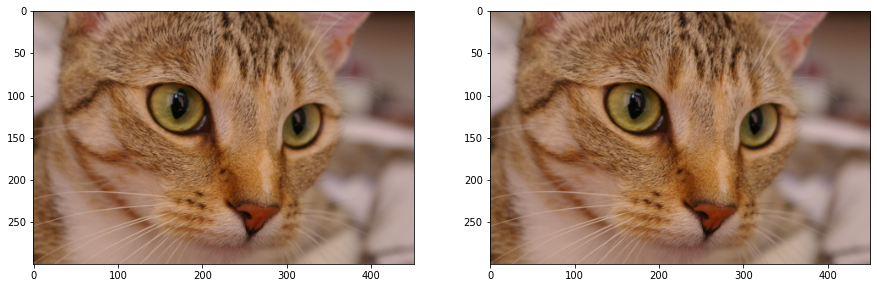

In [73]:
plt.figure(figsize = (15, 15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(img_encoded)
plt.show()

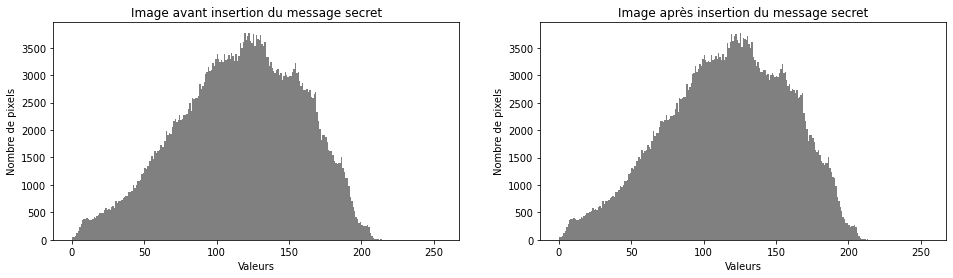

In [74]:
plt.figure(figsize=(16,4))
histogramme(img, "Image avant insertion du message secret", 1)
histogramme(img_encoded, "Image après insertion du message secret", 2)

## Petits tests pour essayer de générer une clé pseudo aléatoire

Ici on a pleins de nombres (plus précisement on a le nombre de lettres du message), qui correspondent aux pixels de l'image que nous allons coder. La clé donné sera 23 et la personne pourra lire le message secret.

**Rappel** : 

- Longueur Y : 300
- Longueur X : 451
- Image en couleur donc 3 pixels par pixel

Nombre de pixels total que l'on peut coder : 405900